### Modelagem Preditiva de Preços de Imóveis

Este notebook desenvolve e avalia modelos de machine learning para estimar o valor de imóveis no Distrito Federal, usando variáveis estruturais e regionais já tratadas nos notebooks anteriores. O foco aqui é modelagem, avaliação e seleção do modelo final.

#### Objetivos
- Estimar valores de imóveis de forma consistente.
- Avaliar impacto das variáveis disponíveis.
- Comparar abordagens lineares e não lineares.
- Validar desempenho com métricas adequadas.
- Preparar modelo para uso em aplicação web.

#### Escopo
- Seleção e preparação das variáveis.
- Divisão treino / teste.
- Pré-processamento e pipelines.
- Ajuste de hiperparâmetros e validação cruzada.
- Avaliação final e salvamento do modelo.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

#### Checagens iniciais e entendimento dos dados

Antes de avançar para a modelagem, realizamos algumas checagens básicas no dataset.  
Aqui avaliamos a estrutura dos dados, tipos das variáveis, valores ausentes, estatísticas descritivas e a distribuição das principais variáveis de interesse, garantindo que o conjunto esteja consistente para os próximos passos.


In [2]:
# Carregand os dados 
df = pd.read_csv(r'C:\analise_imoveis\data\processed\imoveis_df_eda.csv')


In [3]:
# Criando copia do dataset
df_ml = df.copy()

In [4]:
# Checagens Basicas
print('Shape', df_ml.shape)
print('\nColunas', df_ml.columns.tolist())
print('\nTipos:\n', df_ml.dtypes)
print('\nValores ausentes por coluna:\n', df_ml.isnull().sum())
print('\nhead:')
display(df.head())
print('\nResumo numérico:')
display(df_ml[['AREA', 'VALOR', 'VALOR_M2', 'LOG_VALOR_M2']].describe().round(2))

# Top Bairros e cardinalidade
print('\nBairros (top 15):')
print(df['BAIRRO'].value_counts().head(15))

# Assimetria das variaveis de interesse (Skewness)
print('\nAssimetria VALOR_M2', df_ml['VALOR_M2'].skew().round(3))
print('\nAssimetria LOG_VALOR_M2', df_ml['LOG_VALOR_M2'].skew().round(3))

# Contagem por faixa de area
print('\nContagem por faixas de área:')
faixas = pd.cut(df_ml['AREA'], bins=[0,50, 100, 150, 200, 300, 500, 1000])
print(df_ml.groupby(faixas).size())

Shape (9165, 6)

Colunas ['BAIRRO', 'VALOR', 'AREA', 'QUARTOS', 'VALOR_M2', 'LOG_VALOR_M2']

Tipos:
 BAIRRO           object
VALOR           float64
AREA            float64
QUARTOS         float64
VALOR_M2        float64
LOG_VALOR_M2    float64
dtype: object

Valores ausentes por coluna:
 BAIRRO          0
VALOR           0
AREA            0
QUARTOS         0
VALOR_M2        0
LOG_VALOR_M2    0
dtype: int64

head:


,BAIRRO,VALOR,AREA,QUARTOS,VALOR_M2,LOG_VALOR_M2
0,ASA NORTE,1400000.0,141.0,2.0,9929.078014,9.203324
1,NOROESTE,1395000.0,85.0,2.0,16411.764706,9.705815
2,AGUAS CLARAS,850000.0,90.0,3.0,9444.444444,9.153288
3,GUARA,850000.0,68.0,2.0,12500.000000,9.433564
4,LAGO NORTE,2290000.0,411.0,4.0,5571.776156,8.625649



Resumo numérico:


,AREA,VALOR,VALOR_M2,LOG_VALOR_M2
count,9165.00,9165.00,9165.00,9165.00
mean,216.55,1238812.09,7149.15,8.70
std,153.30,722351.15,4119.76,0.62
min,60.00,75000.00,237.50,5.47
25%,100.00,685000.00,3869.97,8.26
50%,170.00,1099000.00,6285.71,8.75
75%,300.00,1620000.00,9440.56,9.15
max,1000.00,3500000.00,19021.74,9.85



Bairros (top 15):
BAIRRO
AGUAS CLARAS       1943
JARDIM BOTANICO    1005
SOBRADINHO          877
VICENTE PIRES       696
GUARA               560
TAGUATINGA          523
ASA NORTE           475
SAMAMBAIA           445
ARNIQUEIRA          426
NOROESTE            419
ASA SUL             360
SUDOESTE            238
PARK WAY            211
CEILANDIA           205
GAMA                198
Name: count, dtype: int64

Assimetria VALOR_M2 0.814

Assimetria LOG_VALOR_M2 -0.402

Contagem por faixas de área:
AREA
(0, 50]           0
(50, 100]      2390
(100, 150]     1727
(150, 200]     1292
(200, 300]     1710
(300, 500]     1570
(500, 1000]     476
dtype: int64


C:\Users\mateu\AppData\Local\Temp\ipykernel_2052\3709343972.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_ml.groupby(faixas).size())


#### Preparação das features e split treino–teste

Este bloco marca o início do pipeline de modelagem.  
Primeiramente, são definidas as variáveis explicativas e a variável alvo (**LOG_VALOR_M2**). As features numéricas incluem área e número de quartos, enquanto a variável categórica **BAIRRO** passa por um tratamento de redução de cardinalidade, mantendo apenas os 10 bairros mais frequentes e agrupando os demais na categoria **OUTROS**.

Por fim, os dados são divididos em conjuntos de treino (**80%**) e teste (**20%**), assegurando que o desempenho do modelo possa ser avaliado em dados não vistos durante o treinamento.


In [5]:
# Definindo features e target
colunas_numericas = ['AREA', 'QUARTOS']
colunas_categoricas = ['BAIRRO']
target = 'LOG_VALOR_M2'

# Agrupando bairros raros em 'OUTROS'
top_bairros = df_ml['BAIRRO'].value_counts().head(10).index.tolist()

print(f'\nTop 10 bairros (mantidos):')
for i, bairro in enumerate(top_bairros, 1):
    count = (df_ml['BAIRRO'] == bairro).sum()
    print(f' {i}. {bairro}: {count} imoveis')

    # Substituindo bairros fora do top 10 por 'OUTROS'
df_ml['BAIRRO_TRATADO'] = df_ml['BAIRRO'].apply(
    lambda x: x if x in top_bairros else 'OUTROS'
)

# Verificando os resultados
print(f'\nDistribuição após tratamento:')
print(df_ml['BAIRRO_TRATADO'].value_counts())


Top 10 bairros (mantidos):
 1. AGUAS CLARAS: 1943 imoveis
 2. JARDIM BOTANICO: 1005 imoveis
 3. SOBRADINHO: 877 imoveis
 4. VICENTE PIRES: 696 imoveis
 5. GUARA: 560 imoveis
 6. TAGUATINGA: 523 imoveis
 7. ASA NORTE: 475 imoveis
 8. SAMAMBAIA: 445 imoveis
 9. ARNIQUEIRA: 426 imoveis
 10. NOROESTE: 419 imoveis

Distribuição após tratamento:
BAIRRO_TRATADO
AGUAS CLARAS       1943
OUTROS             1796
JARDIM BOTANICO    1005
SOBRADINHO          877
VICENTE PIRES       696
GUARA               560
TAGUATINGA          523
ASA NORTE           475
SAMAMBAIA           445
ARNIQUEIRA          426
NOROESTE            419
Name: count, dtype: int64


In [6]:
# Preparando X (features) e y (target)
X = df_ml[colunas_numericas + ['BAIRRO_TRATADO']]
y = df_ml[target]

print(f'\n Features (X): {X.shape}')
print(f'Target (y): {y.shape}')


 Features (X): (9165, 3)
Target (y): (9165,)


In [7]:
# Dividindo em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split (
    X, y,
    test_size = 0.2,
    random_state=42 
)

print(f'\nTreino: {X_train.shape[0]} amostras({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'\nTeste: {X_test.shape[0]} amostras({X_test.shape[0]/len(X)*100:.1f}%)')

print(f'\nDistribuição de BAIRRO no treino:')
print(X_train['BAIRRO_TRATADO'].value_counts())

print(f'\nResumo do target (LOG_VALOR_M2) no treino:')
print(y_train.describe().round(3))

print('\n Dados dividids com sucesso.')


Treino: 7332 amostras(80.0%)

Teste: 1833 amostras(20.0%)

Distribuição de BAIRRO no treino:
BAIRRO_TRATADO
AGUAS CLARAS       1560
OUTROS             1440
JARDIM BOTANICO     793
SOBRADINHO          715
VICENTE PIRES       563
GUARA               442
TAGUATINGA          424
ASA NORTE           375
SAMAMBAIA           357
ARNIQUEIRA          340
NOROESTE            323
Name: count, dtype: int64

Resumo do target (LOG_VALOR_M2) no treino:
count    7332.000
mean        8.689
std         0.624
min         5.474
25%         8.257
50%         8.736
75%         9.141
max         9.853
Name: LOG_VALOR_M2, dtype: float64

 Dados dividids com sucesso.


#### Pré-processamento: padronização e codificação

Modelos de aprendizado de máquina exigem que as variáveis estejam em formato numérico e, preferencialmente, na mesma escala.  
Neste bloco, as variáveis numéricas (**AREA** e **QUARTOS**) são padronizadas com **StandardScaler**, enquanto a variável categórica **BAIRRO_TRATADO** é convertida em variáveis dummies utilizando **OneHotEncoder**.

O transformador é ajustado apenas com os dados de treino e, em seguida, aplicado ao conjunto de teste, garantindo uma avaliação justa do desempenho do modelo.


In [8]:
# Definindo as colunas numericas e categoricas
colunas_numericas = ['AREA', 'QUARTOS']
colunas_categoricas = ['BAIRRO_TRATADO']

# Criando transformadores
preprocesso = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
    ]
)


#### Validação e ajuste de hiperparâmetros
Ajuste de hiperparâmetros do RandomForest é realizado via Pipeline + busca bayesiana com validação cruzada k-fold, garantindo que todas as transformações sejam aplicadas corretamente em cada dobra. O modelo final é re-treinado com os melhores parâmetros.

In [9]:
# garantindo que tudo esteja dentro de um pipeline

rf_pipeline =  Pipeline(
    steps=[
        ('preprocesso', preprocesso),
        ('model', RandomForestRegressor(
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [10]:
from skopt.space import Integer, Real

In [11]:
# Espaço de busca Bayesiano
search_space = {
    'model__n_estimators': Integer(200, 800),
    'model__max_depth': Integer(8,25),
    'model__min_samples_split': Integer(2, 15),
    'model__min_samples_leaf': Integer(1, 8),
    'model__max_features': Real(0.4, 1.0)
}


In [12]:
from skopt import BayesSearchCV

In [13]:
bayes_search = BayesSearchCV(
    estimator=rf_pipeline,
    search_spaces=search_space,
    n_iter=40,
    cv=10,
    scoring='r2',
    n_jobs=1,
    random_state=42,
    verbose=2
)

In [14]:
bayes_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=602; total time=   0.8s
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=602; total time=   0.8s
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=602; total time=   0.8s
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=602; total time=   0.8s
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=602; total time=   0.8s
[CV] END model__max_depth=15, model__max_features=0.836635445906395, model__min_samples_leaf=8, mod

,estimator,Pipeline(step...m_state=42))])
,search_spaces,"{'model__max_depth': Integer(low=8...m='normalize'), 'model__max_features': Real(low=0.4,...m='normalize'), 'model__min_samples_leaf': Integer(low=1...m='normalize'), 'model__min_samples_split': Integer(low=2...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,40
,scoring,'r2'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,10


Resumo da Validação Final
----------------------------------------
R² CV     : 0.632
R² Treino : 0.710
R² Teste  : 0.632
MAE (R$)  : R$ 1,689.04
RMSE (R$) : R$ 2,378.78
----------------------------------------


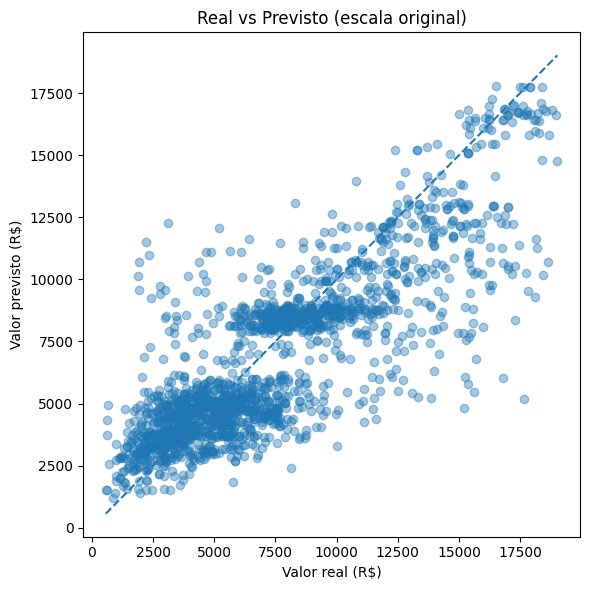

Modelo salvo em: C:\analise_imoveis\models\rf_valor_m2_pipeline.joblib
Metadados salvos em: C:\analise_imoveis\models\metadados\rf_valor_metadata.json


In [15]:
# AVALIAÇÃO FINAL DO MODELO
import json
import joblib
from pathlib import Path
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Melhor modelo treinado
best_model = bayes_search.best_estimator_

# MÉTRICAS (ESCALA LOG)
r2_cv = bayes_search.best_score_
r2_train = best_model.score(X_train, y_train)
r2_test = best_model.score(X_test, y_test)

# PREVISÕES (ESCALA ORIGINAL)
y_pred_log = best_model.predict(X_test)

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)


# MÉTRICAS EM R$
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

# RESUMO
print("Resumo da Validação Final")
print("-" * 40)
print(f"R² CV     : {r2_cv:.3f}")
print(f"R² Treino : {r2_train:.3f}")
print(f"R² Teste  : {r2_test:.3f}")
print(f"MAE (R$)  : R$ {mae:,.2f}")
print(f"RMSE (R$) : R$ {rmse:,.2f}")
print("-" * 40)

# PLOT REAL VS PREVISTO
plt.figure(figsize=(6, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.4)
plt.plot(
    [y_test_orig.min(), y_test_orig.max()],
    [y_test_orig.min(), y_test_orig.max()],
    linestyle="--"
)
plt.xlabel("Valor real (R$)")
plt.ylabel("Valor previsto (R$)")
plt.title("Real vs Previsto (escala original)")
plt.tight_layout()
plt.show()


# SALVAR MODELO E METADADOS
BASE_DIR = Path(r"C:\analise_imoveis")
MODELS_DIR = BASE_DIR / "models"
META_DIR = MODELS_DIR / "metadados"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
META_DIR.mkdir(parents=True, exist_ok=True)

# Salvar pipeline completo
model_path = MODELS_DIR / "rf_valor_m2_pipeline.joblib"
joblib.dump(best_model, model_path)

# Nomes das features (robusto)
try:
    feat_names = best_model.named_steps['preprocesso'].get_feature_names_out()
    feature_list = feat_names.tolist()
except Exception:
    feature_list = X_train.columns.tolist()

metadata = {
    "model_name": "RandomForestRegressor_pipeline",
    "target": "LOG_VALOR_M2",
    "features": feature_list,
    "best_params": bayes_search.best_params_,
    "r2_cv": float(r2_cv),
    "r2_train": float(r2_train),
    "r2_test": float(r2_test),
    "mae": float(mae),
    "rmse": float(rmse),
    "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

metadata_path = META_DIR / "rf_valor_metadata.json"
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"Modelo salvo em: {model_path}")
print(f"Metadados salvos em: {metadata_path}")


## Validação Final do Modelo

### Métricas de desempenho

Os resultados abaixo correspondem à avaliação final do modelo Random Forest,
após o ajuste de hiperparâmetros via busca bayesiana e validação cruzada.

- **R² (CV)**: 0.632  
- **R² (Treino)**: 0.710  
- **R² (Teste)**: 0.632  
- **MAE**: R$ 1.689,04  
- **RMSE**: R$ 2.378,78  

A proximidade entre o R² obtido na validação cruzada e no conjunto de teste
indica boa estabilidade do modelo e ausência de overfitting significativo.
As métricas de erro absoluto (MAE e RMSE) foram calculadas na escala original
dos preços (R$), após a inversão da transformação logarítmica do target.

---

### Análise do gráfico: Real vs Previsto (escala original)

O gráfico de dispersão **Real vs Previsto** apresenta, no eixo X, os valores
reais dos imóveis (R$) e, no eixo Y, os valores previstos pelo modelo. Cada
ponto representa um imóvel, e a linha tracejada indica a predição perfeita
(valores previstos iguais aos valores reais).

#### Principais interpretações

- O conjunto de pontos segue claramente uma tendência diagonal, indicando que
  o modelo capturou adequadamente a relação principal entre as variáveis de
  entrada e o preço dos imóveis.
- Observa-se um comportamento típico de **regressão à média**:
  - Imóveis de menor valor tendem a ser superestimados.
  - Imóveis de maior valor tendem a ser subestimados.
- Há evidência de **compressão nos extremos**, efeito comum em modelos baseados
  em árvores, especialmente quando há poucos exemplos de valores muito altos ou
  muito baixos.
- A presença de **faixas horizontais** sugere que diferentes imóveis recebem
  previsões semelhantes, o que é esperado em Random Forest, já que cada folha
  das árvores retorna a média dos valores observados naquela região do espaço.
- Nota-se **aumento da dispersão dos erros para valores mais altos**, indicando
  heterocedasticidade e maior dificuldade do modelo em prever imóveis de maior
  preço, possivelmente devido a fatores não observados (acabamento, vista,
  padrão construtivo, entre outros).

---

### Diagnóstico final

De forma geral, o modelo apresenta desempenho consistente e comportamento
coerente com o domínio do problema imobiliário. Ele aprende bem a tendência
global dos preços, mantém estabilidade entre treino e teste e apresenta erros
compatíveis com a complexidade do problema e com o conjunto limitado de
variáveis disponíveis. As limitações observadas são esperadas e devidamente
compreendidas, reforçando a confiabilidade da solução para fins de demonstração
e aprendizado.
